In [98]:
'''Import packages for loading data, analysing, and plotting'''
# This cell imports the necessary packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe

import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import os
import matplotlib.colors as colors
import netCDF4 as nc
import tarfile

In [99]:
'''Define pimp generations and model names'''
# This cell lists the models involved in PMIP4 and PMIP3
pmip = {}
pmip['PMIP4'] = ['ACCESS-ESM1-5',
                 'AWI-ESM-2-1-LR',
                 'CESM2',
                 'CNRM-CM6-1',
                 'EC-Earth3-LR',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'GISS-E2-1-G',
                 'HadGEM3-GC31-LL',
                 'INM-CM4-8',
                 'IPSL-CM6A-LR',
                 'MIROC-ES2L',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM1-F',
                 'NorESM2-LM',
                 'UofT-CCSM-4']
pmip['PMIP3'] = ['BCC-CSM1-1',
                 'CCSM4',
                 'CNRM-CM5',
                 'CSIRO-Mk3L-1-2',
                 'CSIRO-Mk3-6-0',
                 'EC-EARTH-2-2',
                 'FGOALS-g2',
                 'FGOALS-s2',
                 'GISS-E2-R',
                 'HadGEM2-CC',
                 'HadGEM2-ES',
                 'IPSL-CM5A-LR',
                 'MIROC-ESM',
                 'MPI-ESM-P',
                 'MRI-CGCM3']
               
               
#expand out the provided data if there isn't already something there
if not os.path.exists('../data/piControl'):
   tar = tarfile.open("data/PMIP4-PMIP3_allfields.tar.gz")
   tar.extractall(path='../data/')
               

In [100]:
#No change needs here
#This cell defines the functions to find variables, models and experiments


#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data/"
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members = [] #create an empty list
    with os.scandir(datadir) as entries:
        for entry in entries:
            this_file=xr.open_dataset(entry,decode_times=False)
            if variable_name in list(this_file.keys()):
                ensemble_members.append(datadir+"/"+entry.name)
            this_file.close()
    return ensemble_members

#This function will list extract model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

#This function will collect member models which have the variable in the experiment
def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


In [101]:
def createfile(pmip_v,experiment_name,variable_name):
    savefile = '%s_%s_%s_emsemble_mean.nc' %(pmip_v,experiment_name,variable_name) 
    lonS = np.arange(-179.5, 180., 1.0) 
    latS = np.arange(-89.5, 90., 1.0) 
    d = Dataset(savefile,'w',format='NETCDF4') 
    d.createDimension('lon',360)  
    d.createDimension('lat',180)  
    d.createVariable("lon",'f',("lon"))  
    d.createVariable("lat",'f',("lat"))  
    d.variables['lat'][:] = latS     
    d.variables['lon'][:] = lonS   
    d.close()
    return savefile

In [102]:
def calculation_ensemble(pmip_v,experiment_name,variable_name,choice): 
    modelfile = '%s_%s_%s_emsemble_mean_models.csv' %(pmip_v,experiment_name,variable_name)
    # Create a netCDF file to save the outputs
    #savefile = createfile(pmip_v,experiment_name,variable_name) #remove this line if you don't want to save the resluts
    #d = Dataset(savefile,'a') #remove this line if you don't want to save the resluts
    model_list = []
    DATA = {}
    data=[]
    var_dict = ensemble_members_dict(variable_name,experiment_name)
    grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    for gcm in var_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)              
                expt_file = xr.open_dataset(var_dict.get(gcm),decode_times=False)
                var = expt_file[variable_name]
                #this_regridder = xe.Regridder(expt_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True)                
                data.append(var)
                if choice == 'model' or 'both': #remove this line if you don't want to save the resluts
                    DATA[gcm] = var
                    #d.createVariable(gcm,'f',("lat",'lon')) #remove this line if you don't want to save the resluts
                    #d.variables[gcm][:] = var_1x1   #remove this line if you don't want to save the resluts                  
    pd.DataFrame(model_list).to_csv(modelfile)
    #if choice == 'mean' or 'both':
        #data1 = np.array(data)
        #ave = var*0
        #ave.values = np.average(data1,axis=0)
        #std = var*0
        #std.values = np.std(data1,axis=0)
        #d.createVariable('ave','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
        #d.variables['ave'][:] = ave  #remove this line if you don't want to save the resluts
        #d.createVariable('std','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
        #d.variables['std'][:] = std #remove this line if you don't want to save the resluts
    #d.close()    #remove this line if you don't want to save the resluts
    #if choice == 'mean':
        #return model_list,ave,std
    if choice == 'model':
        return model_list,DATA
    #if choice == 'both':
        #return model_list,ave,std,DATA

def calculation_ensemble_mean(pmip_v,experiment_name,variable_name,choice): 
    modelfile = '%s_%s_%s_emsemble_mean_models.csv' %(pmip_v,experiment_name,variable_name)
    # Create a netCDF file to save the outputs
    #savefile = createfile(pmip_v,experiment_name,variable_name) #remove this line if you don't want to save the resluts
    #d = Dataset(savefile,'a') #remove this line if you don't want to save the resluts
    model_list = []
    DATA = {}
    data=[]
    var_dict = ensemble_members_dict(variable_name,experiment_name)
    grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    for gcm in var_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)              
                expt_file = xr.open_dataset(var_dict.get(gcm),decode_times=False)
                var = expt_file[variable_name]
                #this_regridder = xe.Regridder(expt_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True)                
                data.append(var)
                if choice == 'model' or 'both': #remove this line if you don't want to save the resluts
                    DATA[gcm] = var
                    #d.createVariable(gcm,'f',("lat",'lon')) #remove this line if you don't want to save the resluts
                    #d.variables[gcm][:] = var_1x1   #remove this line if you don't want to save the resluts                  
    pd.DataFrame(model_list).to_csv(modelfile)
    if choice == 'mean' or 'both':
        data1 = np.array(data)
        ave = var*0
        ave.values = np.average(data1,axis=0)
        std = var*0
        std.values = np.std(data1,axis=0)
        #d.createVariable('ave','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
        #d.variables['ave'][:] = ave  #remove this line if you don't want to save the resluts
        #d.createVariable('std','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
        #d.variables['std'][:] = std #remove this line if you don't want to save the resluts
    #d.close()    #remove this line if you don't want to save the resluts
    if choice == 'mean':
        return model_list,ave,std
    if choice == 'model':
        return model_list,DATA
    #if choice == 'both':
        #return model_list,ave,std,DATA


In [103]:
def calculation_ensemble_change(pmip_v,experiment_name,variable_name):
    modelfile = '%s_%s_%s_emsemble_mean_change_models.csv' %(pmip_v,experiment_name,variable_name)
    # Create a netCDF file to save the outputs
    #savefile = createfile(pmip_v,experiment_name,variable_name) #remove this line if you don't want to save the resluts
    #d = Dataset(savefile,'a') #remove this line if you don't want to save the resluts
    model_list = []
    DATA = {}
    data = []
    A_dict = ensemble_members_dict(variable_name,experiment_name)
    B_dict = ensemble_members_dict(variable_name,'piControl')
    return A_dict,B_dict



In [104]:
pmip_v = "PMIP4" #"PMIP4" or "PMIP3"

In [105]:
experiment_name = "midHolocene" 
#       Period              Experiment name            Name of experiment with calendar adjustment applied
#     mid-Holocene           midHolocene                  midHolocene-cal-adj
#     Last Interglacial       lig127k                     lig127k-cal-adj

In [106]:
#variable_name = "monsoon_rain_EAS" #e.g. the spatial mean of annual mean surface air temperature (deg C)
variable_name = "ipcc_EAS_pr"
# Full list of available variable names can be found in variablenamelist.csv


# The spatial mean variables are named as <variable>_spatialmean_<season>
# commonly used variables:
# tas: surface air temperature (deg C)
# pr: precipitation rate (mm/day)
# psl: sea level pressure (hPa)

# Examples:
# tas_spatialmean_ann: the spatial mean of annual mean surface air temperature (deg C)
# tas_spatialmean_djf: the spatial mean of Dec-Jan-Feb mean surface air temperature (deg C)
# tas_spatialmean_jja: the spatial mean of Jun-Jul-Aug mean surface air temperature (deg C)
# pr_spatialmean_ann: the spatial mean of annual mean precipitation rate (mm/day)
# pr_spatialmean_djf: the spatial mean of Dec-Jan-Feb precipitation rate (mm/day)
# pr_spatialmean_jja: the spatial mean of Jun-Jul-Aug precipitation rate (mm/day)


In [107]:
choice = "model" # "mean", "model" or "both"

# model: save and return the model list and a directory including all absolute values of (or changes in) the rarget variable in the target experimental simulations from each individual model;
# model_list,DATA = calculation_ensemble_change(pmip_v,experiment_name,variable_name,"model")


# mean: save and return the ensemble mean and ensemble standard deviation of the absolute values of (or the changes in) the rarget variable;
# model_list,ave,std = calculation_ensemble_change(pmip_v,experiment_name,variable_name,"mean")


# both: save and return the outputs from both "model" and "mean".
# model_list,ave,std,DATA = calculation_ensemble_change(pmip_v,experiment_name,variable_name,"both")

In [108]:
# e.g.
model_list,DATA = calculation_ensemble(pmip_v,experiment_name,variable_name,'model')# import the ipcc rainfall over EAS for mid-Holocene
model_list_nino,DATA_nino = calculation_ensemble(pmip_v,experiment_name,'nino34',choice)# import the Nino-34 for mid-Holocene
#model_list,DATA = calculation_ensemble_change(pmip_v,experiment_name,variable_name,choice)
#model_list2,ave,std= calculation_ensemble_mean(pmip_v,experiment_name,'nino34',choice="mean")

In [109]:
#time=ave['time']

In [110]:
co=[]#mid-Holocene
nino3_co=[]
nino3=[]
EAS=[]
for model in model_list:
    data=DATA[model]
    data_nino=DATA_nino[model]
    data2=[]
    data3=[]
    for i in np.arange(0,1200,12):
        c=(data_nino[i]+data_nino[i+1]+data_nino[i+11])/3# extract the winter mean from the monthly mean
        d=(data[i]+data[i+1]+data[i+11])/3# extract the winter mean from the monthly mean
        #c=(data_nino[i+5]+data_nino[i+6]+data_nino[i+7])/3# extract the summer mean from the monthly mean
        #d=(data[i+5]+data[i+6]+data[i+7])/3# extract the summer mean from the monthly mean
        data2.append(c)
        data3.append(d)
        #e=np.corrcoef(data2,data3)
        #f=e[1,0]
        #nino3_co.append(f)
        #nino3.append(c)
    EAS.append(np.mean(data3))
    correlation=np.corrcoef(data2,data3)
    corre=correlation[1,0]
    co.append(corre)# calculate the correlation coefficient

In [111]:
model_list_pi,DATA_pi = calculation_ensemble(pmip_v,'piControl',variable_name,'model')# import the ipcc rainfall over EAS for pi-Control
model_list_nino_pi,DATA_nino_pi = calculation_ensemble(pmip_v,'piControl','nino34',choice)# import the Nino-34 for pi-Control

/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amm_pr_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amm_tas_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amo_pr_regression_lowpass_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amo_pr_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all

In [112]:
model_list_pi

['ACCESS-ESM1-5',
 'CESM2',
 'CNRM-CM6-1',
 'EC-Earth3-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'INM-CM4-8',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM1-F',
 'NorESM2-LM',
 'UofT-CCSM-4']

In [113]:
model_list

['CESM2',
 'EC-Earth3-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'INM-CM4-8',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM1-F',
 'NorESM2-LM',
 'UofT-CCSM-4']

In [114]:
co_pi=[]# pi-Control
nino3_co_pi=[]
nino3_pi=[]
EAS_pi=[]
for model in model_list:
    data_pi=DATA_pi[model]
    data_nino_pi=DATA_nino_pi[model]
    data4=[]
    data5=[]
    for i in np.arange(0,1200,12):
        c=(data_nino_pi[i]+data_nino_pi[i+1]+data_nino_pi[i+11])/3# extract the winter mean from the monthly mean
        d=(data_pi[i]+data_pi[i+1]+data_pi[i+11])/3# extract the winter mean from the monthly mean
        #c=(data_nino_pi[i+5]+data_nino_pi[i+6]+data_nino_pi[i+7])/3# extract the sumer mean from the monthly mean
        #d=(data_nino[i+5]+data_nino[i+6]+data_nino[i+7])/3# extract the summer mean from the monthly mean
        data4.append(c)
        data5.append(d)
        #e=np.corrcoef(data2,data3)
        #f=e[1,0]
        #nino3_co.append(f)
        #nino3.append(c)
    correlation=np.corrcoef(data4,data5)
    corre=correlation[1,0]
    co_pi.append(corre)# calculate the correlation coefficient

In [115]:
#plt.scatter(co_pi,model_list)
#plt.scatter(co,model_list)
#plt.legend(['pi-control','mid-Holocene'],loc='best')

In [116]:
co_diff=[]# calculate the correlation difference between pi-Control and mid-Holocene
for i in np.arange(0,15,1):
    co_diff.append(co[i]-co_pi[i])
   
    

In [117]:
obs=xr.open_dataset('C20-Reanalysis_1981-2010.cvdp_data.1871-2012.nc',decode_times=False)#calculate the correlation coefficient for the observational data
obs_pr=obs['ipcc_EAS_pr']
obs_nino=obs['nino34']
data6=[]
data7=[]

for i in np.arange(0,1704,12):
        c=(obs_nino[i]+obs_nino[i+1]+obs_nino[i+11])/3
        d=(obs_pr[i]+obs_pr[i+1]+obs_pr[i+11])/3
        #c=(obs_nino[i+5]+obs_nino[i+6]+obs_nino[i+7])/3
        #d=(obs_pr[i+5]+obs_pr[i+6]+obs_pr[i+7])/3
        data6.append(c)
        data7.append(d)
correlation_obs=np.corrcoef(data6,data7)
corr_obs=correlation_obs[1,0]
      

In [118]:
corr_obs

0.17959272744819413

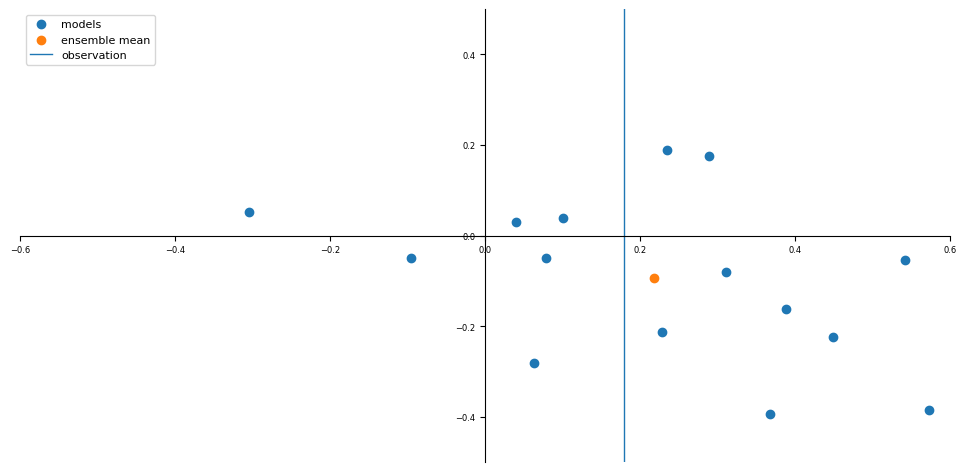

In [122]:
plt.figure(figsize=(12,6)  , dpi=100)# scatter plot
ax = plt.gca()                                           
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')         
ax.xaxis.set_ticks_position('bottom')   
ax.yaxis.set_ticks_position('left')         

ax.spines['bottom'].set_position(('data', 0))   
ax.spines['left'].set_position(('data', 0))
plt.scatter(co_pi,co_diff, s=6**2)# individual models
plt.scatter(np.mean(co_pi),np.mean(co_diff),s=6**2)# ensemble mean
plt.axvline(corr_obs,label='observation',linewidth=1)# obserbvation line
plt.legend(['models','ensemble mean','observation'],loc='upper left',fontsize=8)
#plt.xlabel('pi')
#plt.ylabel('diff')
plt.xlim([-0.6,0.6])
plt.ylim([-0.5,0.5])
plt.savefig('%winter_ENSO_ensemble_mean_mid_Holocene.png')
#plt.savefig('%summer_ENSO_ensemble_mean_mid_Holocene.png')
plt.tick_params(axis='both',which='major',labelsize=6)
plt.show()

